In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from transformers import ViTForImageClassification, ViTConfig
from torch.optim.lr_scheduler import ReduceLROnPlateau

from skimage.metrics import peak_signal_noise_ratio

# Data loading


In [11]:
class NightVisionDataset(Dataset):
    def __init__(self, night_vision_dir, ground_truth_dir, max_samples=20000):
        self.night_vision_dir = night_vision_dir
        self.ground_truth_dir = ground_truth_dir
        self.max_samples = max_samples
        self.night_vision_files = os.listdir(night_vision_dir)
        self.ground_truth_files = os.listdir(ground_truth_dir)

        # Limit the dataset size for memory constraints
        self.night_vision_files = self.night_vision_files[:max_samples]
        self.ground_truth_files = self.ground_truth_files[:max_samples]

        # Define separate transformations for night vision images and ground truth images
        self.transform_night_vision = transforms.Compose(
            [
                transforms.Resize((128, 128)),
                transforms.ToTensor(),  # Convert grayscale to tensor (3 channels)
                transforms.Normalize(
                    mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]
                ),  # Normalize to [0, 1]
            ]
        )

        self.transform_ground_truth = transforms.Compose(
            [
                transforms.Resize((128, 128)),
                transforms.ToTensor(),  # Convert to tensor (no normalization for ground truth)
            ]
        )

    def __len__(self):
        return len(self.night_vision_files)

    def __getitem__(self, idx):
        # Read and process night vision image (grayscale -> 3 channels)
        night_vision_img = cv2.imread(
            os.path.join(self.night_vision_dir, self.night_vision_files[idx]),
            cv2.IMREAD_GRAYSCALE,
        )
        night_vision_img = cv2.cvtColor(
            night_vision_img, cv2.COLOR_GRAY2BGR
        )  # Convert grayscale to 3 channels
        # night_vision_img = cv2.resize(night_vision_img, (128, 128), interpolation = cv2.INTER_LINEAR)
        night_vision_img = Image.fromarray(night_vision_img)
        night_vision_img = self.transform_night_vision(
            night_vision_img
        )  # Apply night vision transformations

        # Read and process ground truth image (RGB)
        ground_truth_img = cv2.imread(
            os.path.join(self.ground_truth_dir, self.ground_truth_files[idx])
        )
        ground_truth_img = cv2.cvtColor(
            ground_truth_img, cv2.COLOR_BGR2RGB
        )  # Convert BGR to RGB
        # ground_truth_img = cv2.resize(ground_truth_img, (128, 128), interpolation = cv2.INTER_LINEAR)
        ground_truth_img = Image.fromarray(ground_truth_img)
        ground_truth_img = self.transform_ground_truth(
            ground_truth_img
        )  # Apply ground truth transformations

        return night_vision_img, ground_truth_img

In [12]:
# File paths
base_dir = "/kaggle/input/imagenet-night-vision"

max_samples = 50000
batch_size = 32

train_X_dir = os.path.join(base_dir, "train", "night_vision")
train_y_dir = os.path.join(base_dir, "train", "ground_truth")
val_X_dir = os.path.join(base_dir, "val", "night_vision")
val_y_dir = os.path.join(base_dir, "val", "ground_truth")

# Create datasets and dataloaders
train_dataset = NightVisionDataset(train_X_dir, train_y_dir, max_samples)
val_dataset = NightVisionDataset(val_X_dir, val_y_dir, max_samples)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Model building


In [13]:
class Encoder(nn.Module):
    def __init__(
        self, vit_model_name="google/vit-base-patch16-224-in21k", num_labels=0
    ):
        super(Encoder, self).__init__()
        # Adjust the ViT configuration for 128x128 images
        config = ViTConfig.from_pretrained(vit_model_name)
        config.image_size = 128
        config.num_labels = num_labels
        config.output_hidden_states = True

        self.encoder = ViTForImageClassification.from_pretrained(
            vit_model_name, config=config, ignore_mismatched_sizes=True
        )

        # Set to not update the encoder during training
        for param in self.encoder.parameters():
            param.requires_grad = (
                False  # Freezing ViT parameters for feature extraction
            )

    def forward(self, x):
        vit_output = self.encoder(x)
        vit_features = vit_output.hidden_states[-1]  # Last hidden state
        vit_features = vit_features.view(vit_features.size(0), -1)  # Flatten the output
        return vit_features


class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(49920, 896)
        self.dropout1 = nn.Dropout(0.6)  # Dropout after the first FC layer
        self.fc2 = nn.Linear(896, 128 * 8 * 8)
        self.dropout2 = nn.Dropout(0.6)  # Dropout after the second FC layer

        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1)
        self.deconv4 = nn.ConvTranspose2d(16, 3, kernel_size=4, stride=2, padding=1)

        self.elu = nn.ELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.elu(x)
        x = self.dropout1(x)  # Apply dropout

        x = self.fc2(x)
        x = self.elu(x)
        x = self.dropout2(x)  # Apply dropout

        x = x.view(x.size(0), 128, 8, 8)

        x = self.deconv1(x)
        x = self.elu(x)
        x = self.deconv2(x)
        x = self.elu(x)
        x = self.deconv3(x)
        x = self.elu(x)
        x = self.deconv4(x)
        x = self.sigmoid(x)

        return x


class HierarchicalVisionTransformerModel(nn.Module):
    def __init__(self):
        super(HierarchicalVisionTransformerModel, self).__init__()
        self.encoder = Encoder(
            vit_model_name="google/vit-base-patch16-224-in21k", num_labels=0
        )
        self.decoder = Decoder()

    def forward(self, x):
        encoded_features = self.encoder(x)
        reconstructed_image = self.decoder(encoded_features)
        return reconstructed_image

In [14]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")

if device == "cuda":
    torch.cuda.empty_cache()


# Initialize the model and move it to the appropriate device
model = HierarchicalVisionTransformerModel().to(device)

Using cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized because the shapes did not match:
- embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 65, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Training the model


In [15]:
# Callbacks
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.best_val_loss = float("inf")
        self.counter = 0

    def __call__(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.counter = 0
            if self.verbose:
                print(f"Validation loss improved to {val_loss:.4f}")
            return False  # Do not stop
        else:
            self.counter += 1
            if self.verbose:
                print(
                    f"Validation loss did not improve. Counter: {self.counter}/{self.patience}"
                )
            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered!")
                return True  # Stop training
        return False


class ModelCheckpoint:
    def __init__(self, filepath, verbose=True):
        self.filepath = filepath
        self.verbose = verbose
        self.best_val_loss = float("inf")

    def __call__(self, model, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            torch.save(model.state_dict(), self.filepath)
            if self.verbose:
                print(
                    f"Model saved at {self.filepath}. Validation loss: {val_loss:.4f}"
                )

In [16]:
# Parameters
epochs = 30
learning_rate = 1e-4
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-5)


# Callbacks
best_model_path = "best_model.pth"

early_stopping = EarlyStopping(patience=10)
model_checkpoint = ModelCheckpoint(filepath=best_model_path)
LRscheduler = ReduceLROnPlateau(
    optimizer, mode="min", patience=3, factor=0.1, verbose=True
)

callbacks = [early_stopping, model_checkpoint, LRscheduler]

In [17]:
# Model training function
def train_model(
    model, train_loader, val_loader, epochs, criterion, optimizer, device, callbacks
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0

        for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        LRscheduler.step(avg_val_loss)  # Adjust learning rate based on validation loss

        print(
            f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}"
        )
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)

        # Callbacks
        for callback in callbacks:
            if isinstance(callback, ReduceLROnPlateau):
                callback.step(avg_val_loss)  # Learning Rate scheduler step

            elif isinstance(callback, EarlyStopping):
                if callback(avg_val_loss):  # Check for early stopping
                    return (train_losses, val_losses)

            elif isinstance(callback, ModelCheckpoint):
                callback(model, avg_val_loss)  # Save best model

    return (train_losses, val_losses)

In [18]:
# Staring the training process
train_losses, val_losses = train_model(
    model, train_loader, val_loader, epochs, criterion, optimizer, device, callbacks
)

Epoch 1/30: 100%|██████████| 1259/1259 [08:22<00:00,  2.51it/s]


Epoch [1/30] - Train Loss: 0.0687 - Val Loss: 0.0650
Validation loss improved to 0.0650
Model saved at best_model.pth. Validation loss: 0.0650


Epoch 2/30: 100%|██████████| 1259/1259 [08:13<00:00,  2.55it/s]


Epoch [2/30] - Train Loss: 0.0635 - Val Loss: 0.0643
Validation loss improved to 0.0643
Model saved at best_model.pth. Validation loss: 0.0643


Epoch 3/30: 100%|██████████| 1259/1259 [08:07<00:00,  2.58it/s]


Epoch [3/30] - Train Loss: 0.0611 - Val Loss: 0.0632
Validation loss improved to 0.0632
Model saved at best_model.pth. Validation loss: 0.0632


Epoch 4/30: 100%|██████████| 1259/1259 [08:15<00:00,  2.54it/s]


Epoch [4/30] - Train Loss: 0.0596 - Val Loss: 0.0664
Validation loss did not improve. Counter: 1/10


Epoch 5/30: 100%|██████████| 1259/1259 [08:14<00:00,  2.55it/s]


Epoch [5/30] - Train Loss: 0.0587 - Val Loss: 0.0623
Validation loss improved to 0.0623
Model saved at best_model.pth. Validation loss: 0.0623


Epoch 6/30: 100%|██████████| 1259/1259 [08:06<00:00,  2.59it/s]


Epoch [6/30] - Train Loss: 0.0578 - Val Loss: 0.0630
Validation loss did not improve. Counter: 1/10


Epoch 7/30: 100%|██████████| 1259/1259 [08:07<00:00,  2.58it/s]


Epoch [7/30] - Train Loss: 0.0570 - Val Loss: 0.0616
Validation loss improved to 0.0616
Model saved at best_model.pth. Validation loss: 0.0616


Epoch 8/30: 100%|██████████| 1259/1259 [08:10<00:00,  2.57it/s]


Epoch [8/30] - Train Loss: 0.0566 - Val Loss: 0.0615
Validation loss improved to 0.0615
Model saved at best_model.pth. Validation loss: 0.0615


Epoch 9/30: 100%|██████████| 1259/1259 [08:11<00:00,  2.56it/s]


Epoch [9/30] - Train Loss: 0.0559 - Val Loss: 0.0626
Validation loss did not improve. Counter: 1/10


Epoch 10/30: 100%|██████████| 1259/1259 [08:14<00:00,  2.55it/s]


Epoch [10/30] - Train Loss: 0.0554 - Val Loss: 0.0620
Validation loss did not improve. Counter: 2/10


Epoch 11/30: 100%|██████████| 1259/1259 [08:14<00:00,  2.55it/s]


Epoch [11/30] - Train Loss: 0.0540 - Val Loss: 0.0621
Validation loss did not improve. Counter: 3/10


Epoch 12/30: 100%|██████████| 1259/1259 [08:10<00:00,  2.57it/s]


Epoch [12/30] - Train Loss: 0.0536 - Val Loss: 0.0625
Validation loss did not improve. Counter: 4/10


Epoch 13/30: 100%|██████████| 1259/1259 [08:05<00:00,  2.60it/s]


Epoch [13/30] - Train Loss: 0.0532 - Val Loss: 0.0625
Validation loss did not improve. Counter: 5/10


Epoch 14/30: 100%|██████████| 1259/1259 [08:09<00:00,  2.57it/s]


Epoch [14/30] - Train Loss: 0.0533 - Val Loss: 0.0625
Validation loss did not improve. Counter: 6/10


Epoch 15/30: 100%|██████████| 1259/1259 [08:03<00:00,  2.60it/s]


Epoch [15/30] - Train Loss: 0.0532 - Val Loss: 0.0625
Validation loss did not improve. Counter: 7/10


Epoch 16/30: 100%|██████████| 1259/1259 [08:04<00:00,  2.60it/s]


Epoch [16/30] - Train Loss: 0.0531 - Val Loss: 0.0626
Validation loss did not improve. Counter: 8/10


Epoch 17/30: 100%|██████████| 1259/1259 [08:07<00:00,  2.58it/s]


Epoch [17/30] - Train Loss: 0.0532 - Val Loss: 0.0626
Validation loss did not improve. Counter: 9/10


Epoch 18/30: 100%|██████████| 1259/1259 [08:04<00:00,  2.60it/s]


Epoch [18/30] - Train Loss: 0.0532 - Val Loss: 0.0626
Validation loss did not improve. Counter: 10/10
Early stopping triggered!


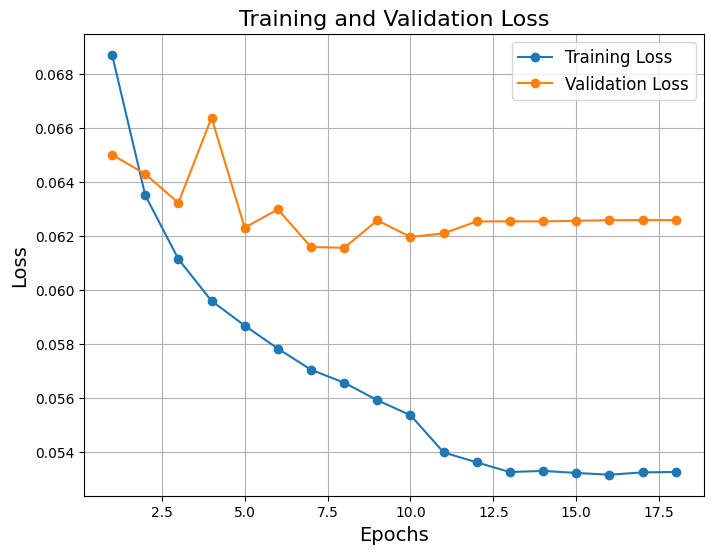

In [19]:
# Function to plot the training and validation loss curve
def plot_loss(train_losses, val_losses):
    epochs = range(1, len(train_losses) + 1)  # x-axis values

    plt.figure(figsize=(8, 6))
    plt.plot(epochs, train_losses, label="Training Loss", marker="o")
    plt.plot(epochs, val_losses, label="Validation Loss", marker="o")
    plt.title("Training and Validation Loss", fontsize=16)
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss", fontsize=14)
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()


plot_loss(train_losses, val_losses)

# Evaluating the model


In [20]:
# Load best model
model.load_state_dict(torch.load(best_model_path))

<ipython-input-20-77a7f7ca3d76>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


<All keys matched successfully>

In [21]:
# Load the test set
test_X_dir = os.path.join(base_dir, "test", "night_vision")
test_y_dir = os.path.join(base_dir, "test", "ground_truth")

test_dataset = NightVisionDataset(test_X_dir, test_y_dir, max_samples=max_samples)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
def calculate_psnr(original_image, reconstructed_image):
    # Compute PSNR
    psnr_value = peak_signal_noise_ratio(
        original_image.cpu().numpy(), reconstructed_image.cpu().numpy()
    )
    return psnr_value


def evaluate_model(model, test_loader, criterion, device):
    model.eval()

    best_images = []
    worst_images = []
    all_errors = []

    psnr = []
    ssim = []

    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            night_vision, ground_truth = inputs.to(device), targets.to(device)

            # Get predictions
            predictions = model(night_vision)

            # Calculate batch-wise MSE
            batch_mse = criterion(predictions, ground_truth).item()
            all_errors.append(batch_mse)

            # Calculate per-sample MSE for sorting
            sample_mse = (
                torch.mean((predictions - ground_truth) ** 2, dim=(1, 2, 3))
                .cpu()
                .numpy()
            )

            # Save predictions for the best and worst images
            for idx, mse in enumerate(sample_mse):
                best_images.append(
                    (
                        mse,
                        night_vision[idx].cpu(),
                        predictions[idx].cpu(),
                        ground_truth[idx].cpu(),
                    )
                )
                worst_images.append(
                    (
                        mse,
                        night_vision[idx].cpu(),
                        predictions[idx].cpu(),
                        ground_truth[idx].cpu(),
                    )
                )

            for index in range(len(predictions)):
                psnr.append(calculate_psnr(ground_truth[index], predictions[index]))

    # Sort by error
    best_images = sorted(best_images, key=lambda x: x[0])[:5]  # 5 best
    worst_images = sorted(worst_images, key=lambda x: x[0], reverse=True)[:5]  # 5 worst

    average_psnr = sum(psnr) / len(psnr)

    return best_images, worst_images, np.mean(all_errors), average_psnr

In [23]:
best_images, worst_images, avg_mse, average_psnr = evaluate_model(
    model, test_loader, criterion, device
)

# Print average MSE
print(f"Average MSE on Test Set: {avg_mse:.4f}")

Evaluating: 100%|██████████| 157/157 [02:42<00:00,  1.04s/it]

Average MSE on Test Set: 0.0629


In [24]:
print(f"Average PSNR on Test Set: {average_psnr:.4f}")

Average PSNR on Test Set: 12.1580


In [25]:
def plot_comparison(image_data, title="Comparison"):
    """
    Plot a comparison of night vision input, model predictions, and ground truth images.

    Args:
        image_data (list): List of tuples (MSE, night_vision, prediction, ground_truth).
        title (str): Title of the plot.
    """
    num_images = len(image_data)
    fig, axes = plt.subplots(num_images, 3, figsize=(12, 4 * num_images))
    fig.suptitle(title, fontsize=16)

    for i, (mse, night_vision, prediction, ground_truth) in enumerate(image_data):
        # Scale to 0-255 and convert to uint8
        night_vision_img = (
            (night_vision.permute(1, 2, 0).numpy() * 255).clip(0, 255).astype("uint8")
        )
        prediction_img = (
            (prediction.permute(1, 2, 0).numpy() * 255).clip(0, 255).astype("uint8")
        )
        ground_truth_img = (
            (ground_truth.permute(1, 2, 0).numpy() * 255).clip(0, 255).astype("uint8")
        )

        # Plot night vision
        axes[i, 0].imshow(night_vision_img)
        axes[i, 0].set_title("Night Vision Input")
        axes[i, 0].axis("off")

        # Plot prediction
        axes[i, 1].imshow(prediction_img)
        axes[i, 1].set_title(f"Prediction (MSE: {mse:.4f})")
        axes[i, 1].axis("off")

        # Plot ground truth
        axes[i, 2].imshow(ground_truth_img)
        axes[i, 2].set_title("Ground Truth")
        axes[i, 2].axis("off")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

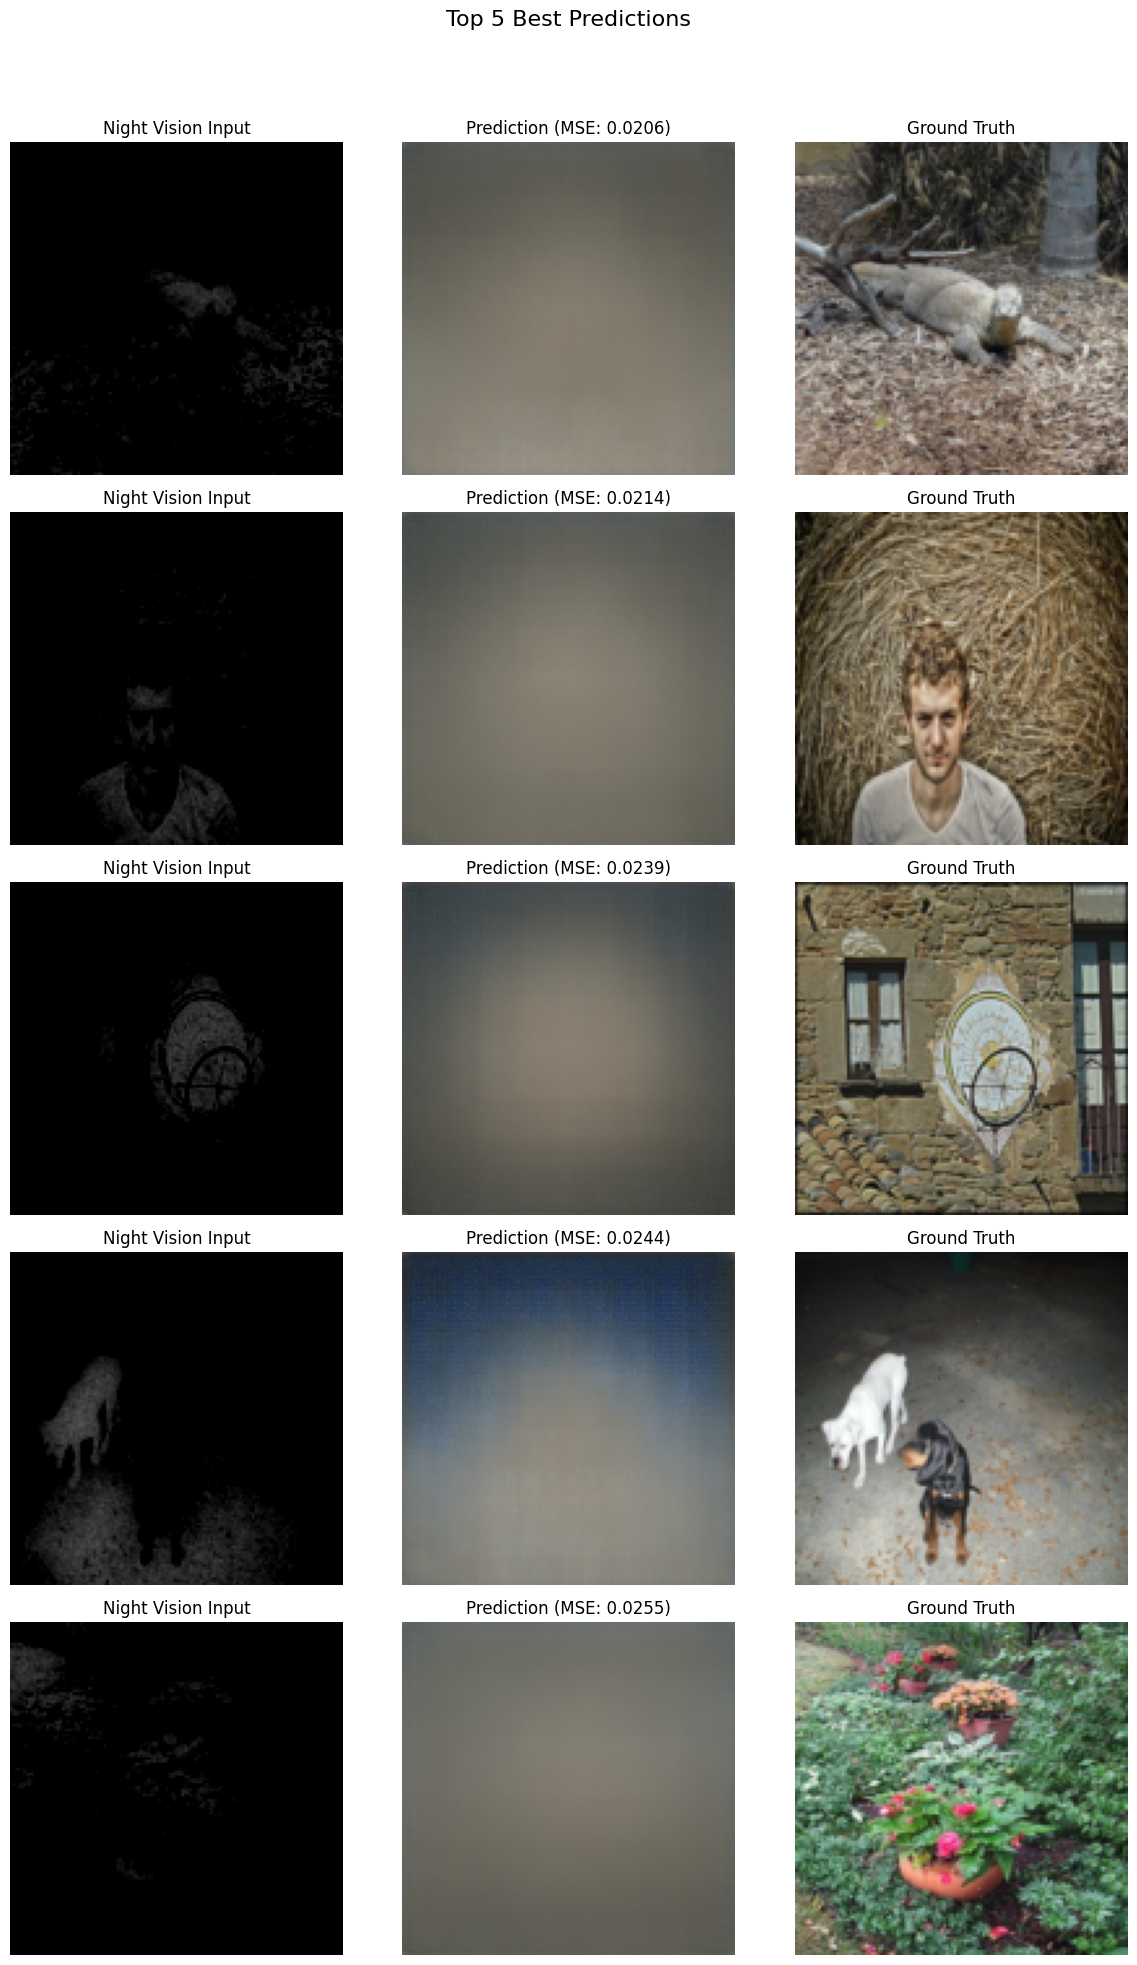

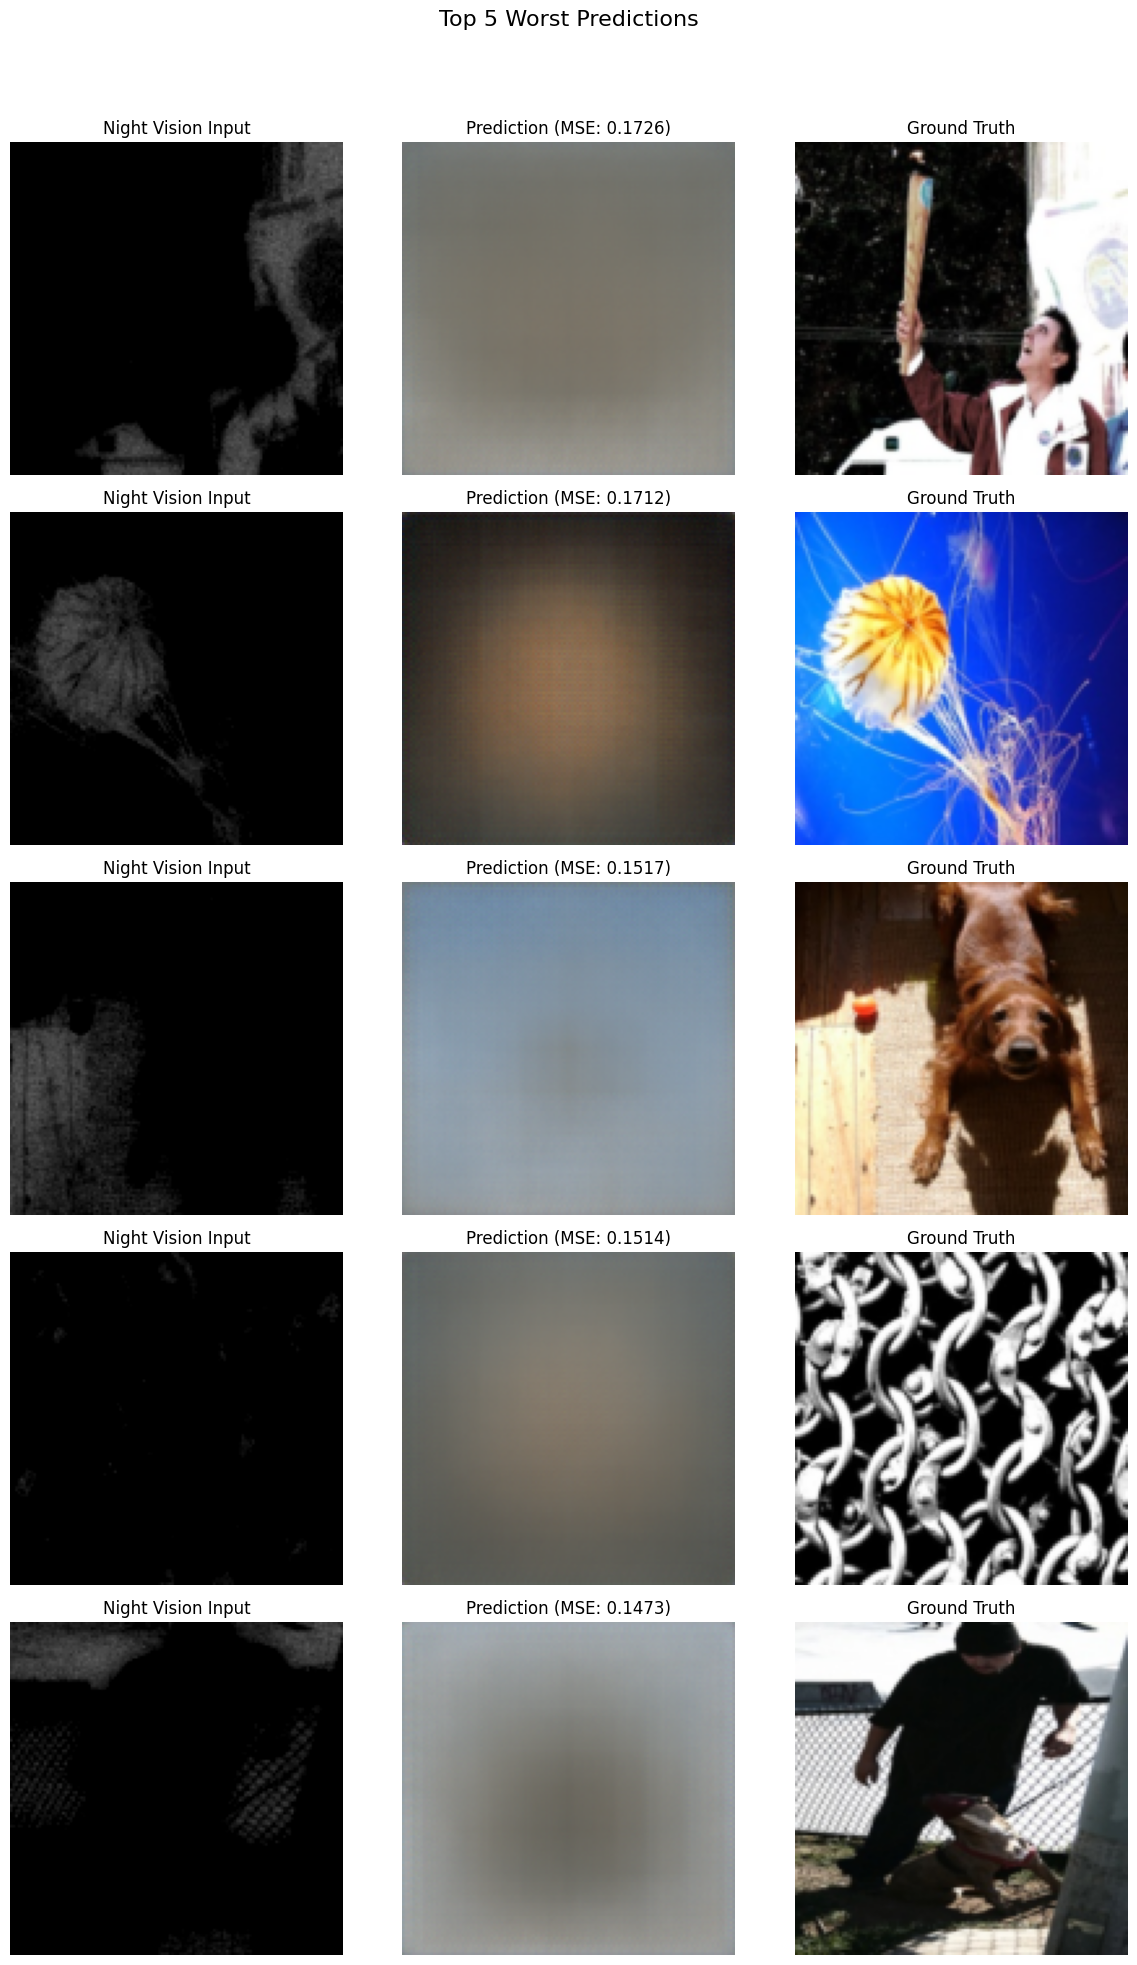

In [26]:
# Plot best and worst predictions
plot_comparison(best_images, title="Top 5 Best Predictions")
plot_comparison(worst_images, title="Top 5 Worst Predictions")

Evaluating: 100%|██████████| 157/157 [01:02<00:00,  2.53it/s]


Average MSE on Val Set: 0.0615


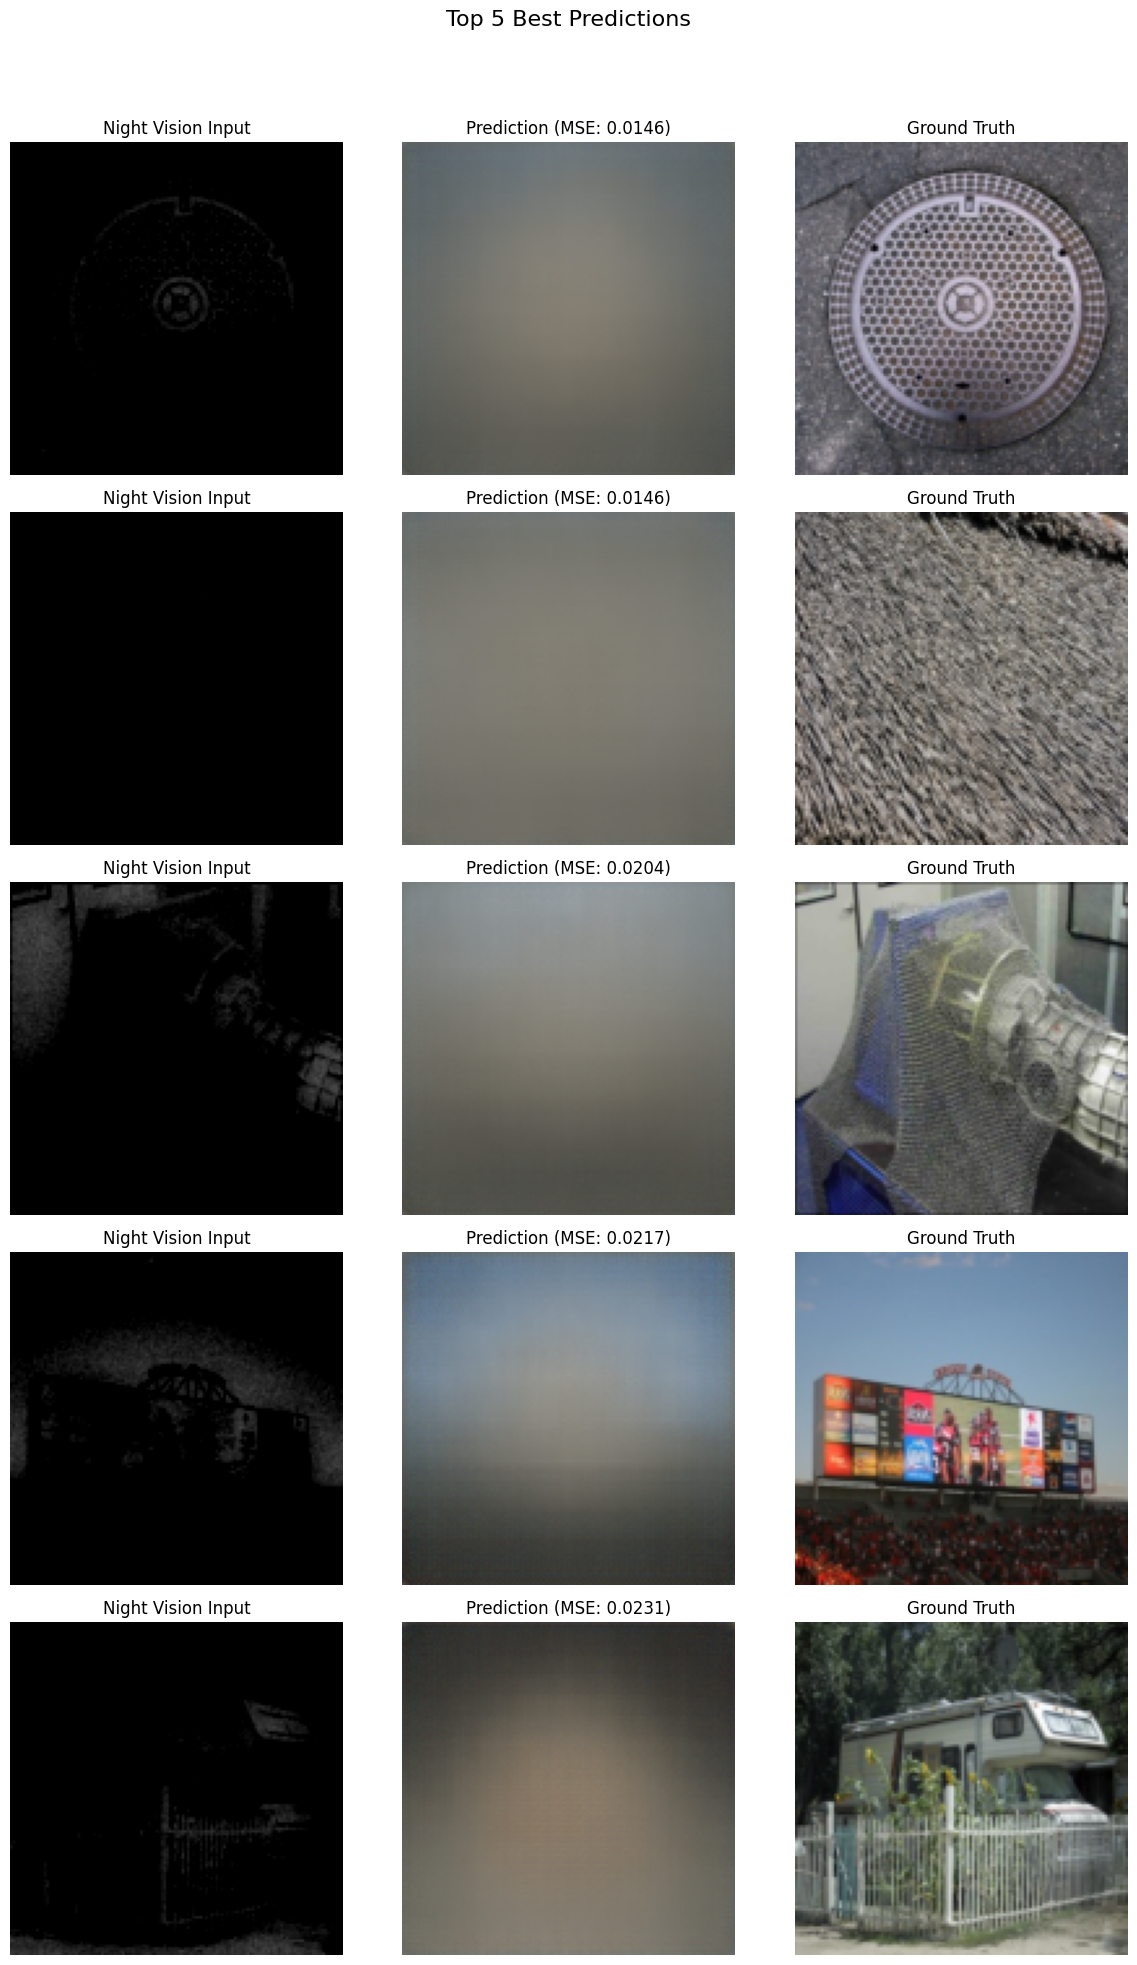

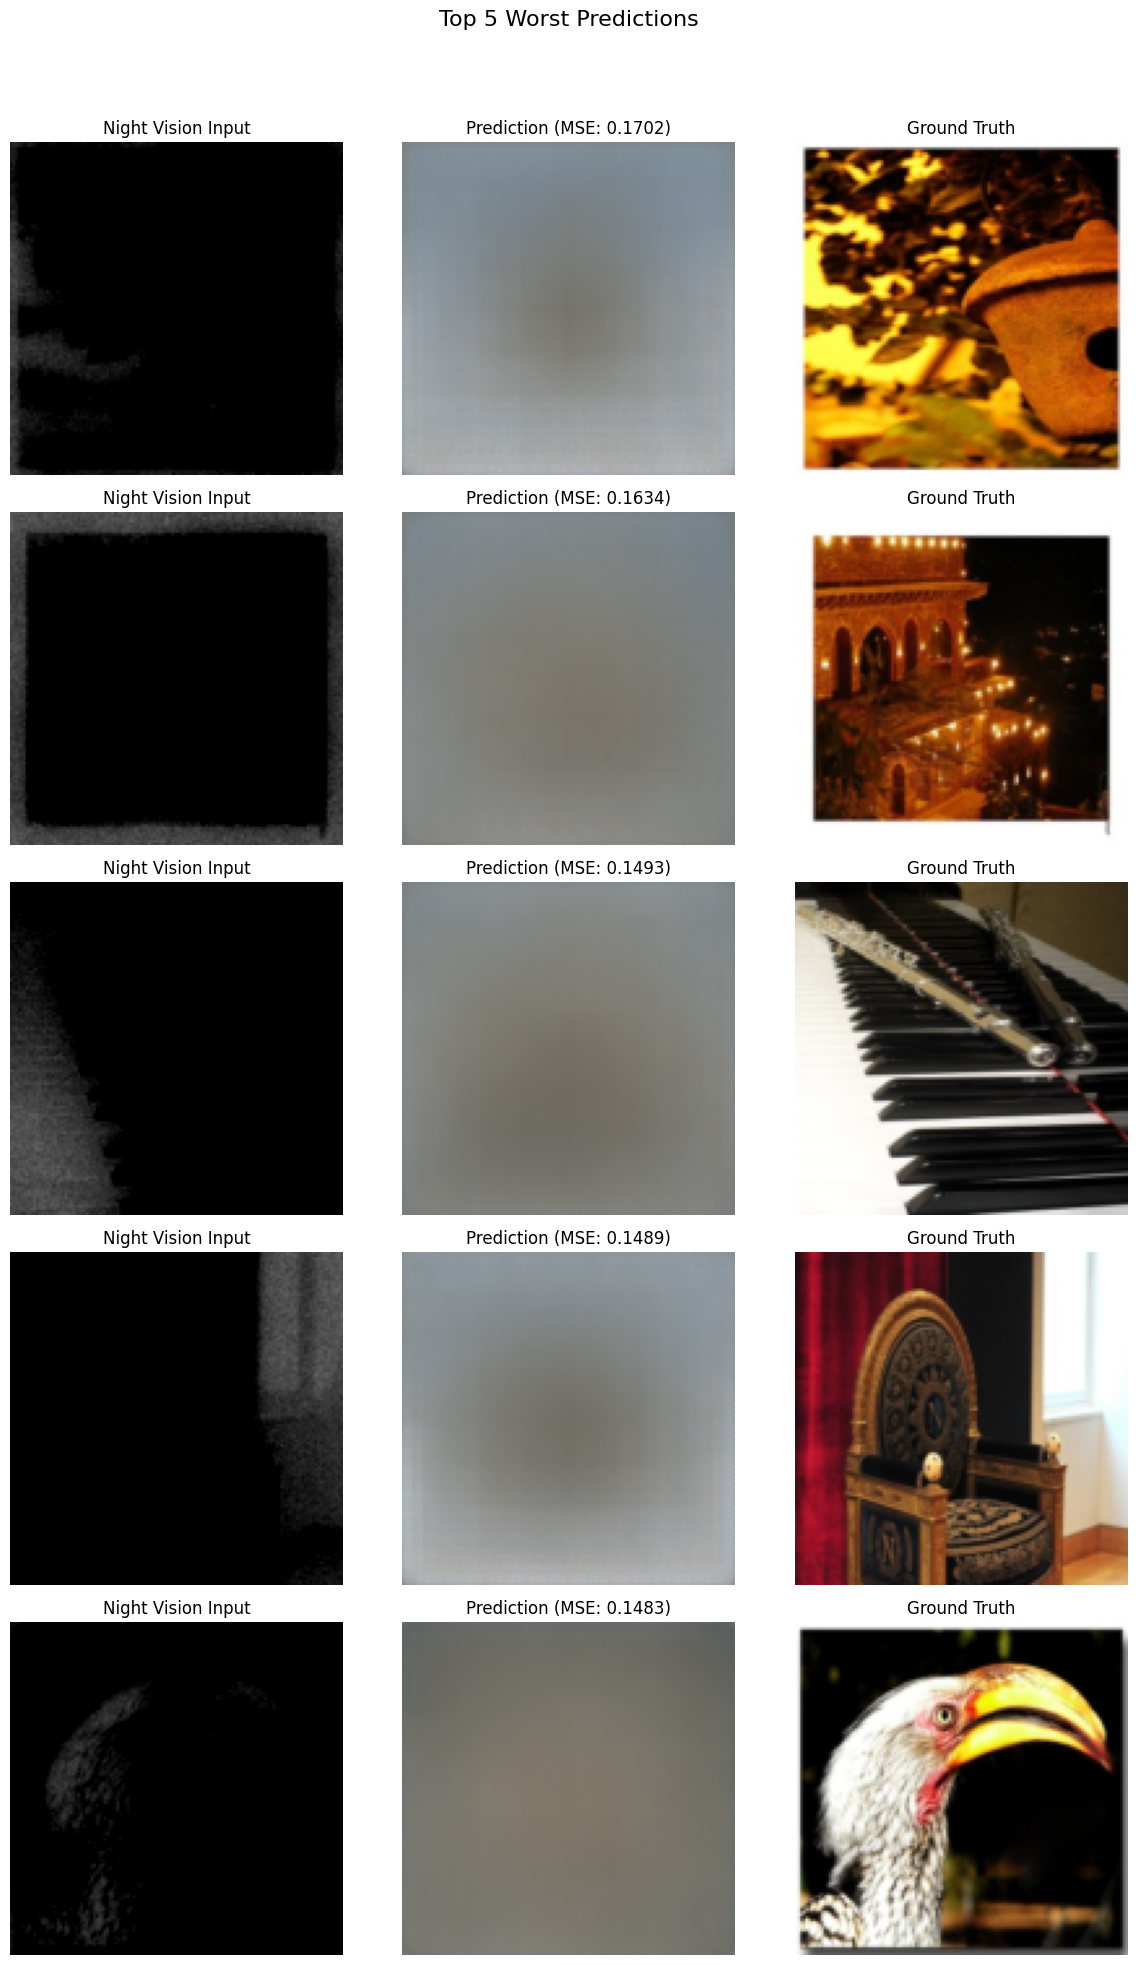

In [27]:
# Evauating the VAL set

best_images, worst_images, avg_mse, average_psnr = evaluate_model(
    model, val_loader, criterion, device
)

# Print average MSE
print(f"Average MSE on Val Set: {avg_mse:.4f}")

# Plot best and worst predictions
plot_comparison(best_images, title="Top 5 Best Predictions")
plot_comparison(worst_images, title="Top 5 Worst Predictions")